In [1]:
import numpy as np
import pandas as pd
import copy
import math
import time
import random
import operator
import datetime
import csv
from sklearn.metrics.pairwise import euclidean_distances

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

## Model

In [2]:
class Customer():
    def __init__(self, cust_id, x, y, demand, ready_time, due_date, service_time):
        self.cust_id = cust_id
        self.x = x
        self.y = y
        self.demand = demand
        self.ready_time = ready_time
        self.due_date = due_date
        self.service_time = service_time
        
    def __repr__(self):
        return f"Customer: <{self.cust_id:3}, {self.x:2}, {self.y:2}, {self.demand:2}, " \
               f"{self.ready_time:3}, {self.due_date:4}, {self.service_time:2}>"

In [5]:
class Vehicle():
    def __init__(self, capacity, depot, distances):
        self.depot = depot
        self.route = [depot]
        self.time_points = [depot.ready_time]
        self.initial_capacity = capacity
        self.left_capacity = capacity
        self.d = distances
        self.total_time = 0
        
        self.distances = [0]
    
    def can_visit(self, c):
        if (self.left_capacity >= c.demand):
            travel_time = self.d[self.route[-1].cust_id][c.cust_id]
            have_time_to_visit_customer = self.total_time + travel_time < c.due_date
            if (have_time_to_visit_customer):
                time_to_depot = self.d[c.cust_id][self.depot.cust_id]
                have_time_to_go_home = self.total_time + travel_time + c.service_time + time_to_depot < self.depot.due_date
                if (have_time_to_go_home):
                    return True
        return False
    
    def visit(self, c):
        self.left_capacity -= c.demand
        distance_to_customer = self.d[self.route[-1].cust_id][c.cust_id]
        self.distances.append(distance_to_customer)
        self.total_time += distance_to_customer
        if (self.total_time < c.ready_time):
            self.total_time = c.ready_time
        self.time_points.append(self.total_time)
        self.total_time += c.service_time
        self.route.append(c)
        
    def length(self):
        return len(self.route)
    
    def distance(self):
        return sum(self.distances)
    
    def print_info(self):
        for c, time, dist in zip(self.route, self.time_points, self.distances):
            print(f"{c.cust_id:3} demand={c.demand:2} dist={dist:6.3f} "
                  f"time={time:7.2f} tw=({c.ready_time:3},{c.due_date:4}) "
                  f"service_time={c.service_time:2} ->")
        print(f"Final time = {self.total_time:5.3f}, distance = {self.distance():6.2f}, "
              f"length={self.length():2}, left_capafcity = {self.left_capacity}")
    
    def __repr__(self):
        return str([c.cust_id for c in self.route])

## Utils

In [3]:
def read_instance_data(file_path):
    customers = []
    with open(file_path, 'r') as f:
        output = f.readlines()
        for i, line in enumerate(output, start=1):
            #skip lines with no significant info
            if i in [1, 2, 3, 4, 6, 7, 8, 9]:
                continue
            line = line.strip()
            if i == 5:
                n_vehicles, capacity = map(int, line.split())
            else:
                cust_id, x, y, demand, ready_time, due_date, service_time = map(int, line.split())
                c = Customer(cust_id, x, y, demand, ready_time, due_date, service_time)
                customers.append(c)
    return n_vehicles, capacity, customers

In [4]:
def calculate_distances(customers):
    coords = [(c.x, c.y) for c in customers]
    return euclidean_distances(coords, coords)

In [6]:
def run_vehicle(customers, distances, capacity, depot):
    def get_most_suitable(current, candidates):
        values = [distances[current.cust_id][c.cust_id] * c.ready_time * c.due_date 
                  for c in candidates]
        return candidates[np.argmin(values)]

    v = Vehicle(capacity, depot, distances)
    candidates = customers[:]
    while candidates:
        if (v.left_capacity < min([c.demand for c in candidates])):
            break
        candidate = get_most_suitable(v.route[-1], candidates)
        if (v.can_visit(candidate)):
            v.visit(candidate)
        candidates.remove(candidate)
    v.visit(v.depot) # it works only if depot has no demand and no servise_time
    
    return v

In [7]:
def get_greedy_solution(customers, distances, n_vehicles, vehicle_capacity):
    solution = []
    n_used_vehicles = 0
    depot = customers[0]
    candidates = customers[1:]
    while candidates and n_used_vehicles < n_vehicles:
        n_used_vehicles += 1
        v = run_vehicle(candidates, distances, vehicle_capacity, depot)
        solution.append(v)
        candidates = [c for c in candidates if c not in v.route]
    return solution

In [8]:
def get_time(solution):
    return sum([v.total_time for v in solution])

def get_distance(solution):
    return sum([v.distance() for v in solution])

def remove_empty_routes(sol):
    return [v for v in sol if v.length() > 2]

In [9]:
def print_solution_info(solution, verbose=False):
    print(f"Total solution time = {get_time(solution):.2f}, "
          f"distance = {get_distance(solution):.2f}, vehicles = {len(solution)}:")
    for i, v in enumerate(sorted(solution, key=lambda v: v.distance())):
        if verbose:
            print('-' * 75)
            v.print_info()
        else:
            print(f"{i+1:2}) Time={v.total_time:7.2f}, distance={v.distance():6.2f}, "
                  f"length={v.length():2}, left capacity={v.left_capacity:3}: {v}")

In [10]:
def draw_solution(sol, title=''):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(sol)), 
                                   cmap=plt.get_cmap('gist_rainbow'))
    
    c_x, c_y = [], []
    for v_i, v in enumerate(sorted(sol, key=lambda v: v.length())):
        c_x = np.array([c.x for c in v.route])
        c_y = np.array([c.y for c in v.route])
        c_edges = np.array([[i, i + 1] for i in range(len(v.route) - 1)])
        color = scalarMap.to_rgba(v_i)
        plt.plot(c_x[c_edges.T], c_y[c_edges.T], 
                 linestyle='-', color=color, linewidth=1.5,
                 markerfacecolor=color, marker='o', markersize=4)
    
    #Mark the depot
    plt.plot(c_x[0], c_y[0], color='green', marker='s', markersize=20)
    
    plt.title(title)
    plt.show()

In [11]:
def check_route(route, capacity, distances):
    v = Vehicle(capacity, route[0], distances)
    is_valid = True
    for c in route[1:]:
        if (v.can_visit(c)):
            v.visit(c)
        else:
            is_valid = False
            break
    return is_valid, v

In [12]:
def rng(v, with_last):
    return range(1, v.length()) if with_last else range(1, v.length() - 1)

### Operators

In [13]:
def cross(v1, i, v2, j):
    new_first_route  = v1.route[:i] + v2.route[j:]
    new_second_route = v2.route[:j] + v1.route[i:]
    return new_first_route, new_second_route

def exchange(v1, i, v2, j):
    new_first_route, new_second_route = v1.route[:], v2.route[:]
    new_first_route[i], new_second_route[j] = new_second_route[j], new_first_route[i]
    return new_first_route, new_second_route

def relocate(v1, i, v2, j):
    new_first_route, new_second_route  = v1.route[:], v2.route[:]
    c = new_first_route[i]
    new_first_route.remove(c)
    new_second_route.insert(j, c)
    return new_first_route, new_second_route

## Local Search

In [14]:
def local_search(sol, max_attempts = 200_000):
    class ExceededLimitException(Exception):
        pass
    
    def intra_relocate(sol):
        move_done = False
        result_sol = copy.deepcopy(sol)
        random.shuffle(result_sol)
        for v_i, v in enumerate(result_sol):
            best_v = v
            for i in range(1, v.length() - 1):
                for j in range(1, v.length() - 1):
                    if i == j:
                        continue
                    local_search.n_attempts += 1
                    if local_search.n_attempts == local_search.max_attempts:
                        raise ExceededLimitException
                    new_route = copy.deepcopy(v.route)
                    c = new_route[i]
                    new_route.remove(c)
                    new_route.insert(j, c)
                    route_is_valid, new_v = check_route(new_route, v.initial_capacity, v.d)
                    if route_is_valid:
                        gain = best_v.distance() - new_v.distance()
                        if gain > 1e-3:
                            best_v = new_v
                            move_done = True                                    
                            result_sol[v_i] = best_v
                            return move_done, result_sol
        return move_done, result_sol
    
    def apply_operator(sol, operator, with_last):
        move_done = False
        result_sol = copy.deepcopy(sol)
        random.shuffle(result_sol)
        for v1 in result_sol:
            for v2 in result_sol:
                if v1 != v2:
                    for i in rng(v1, with_last):
                        for j in rng(v2, with_last):
                            local_search.n_attempts += 1
                            if local_search.n_attempts == local_search.max_attempts:
                                raise ExceededLimitException
                            
                            new_first_route, new_second_route = operator(v1, i, v2, j)
                            first_is_valid, new_v1 = check_route(new_first_route, v1.initial_capacity, v1.d)
                            second_is_valid, new_v2 = check_route(new_second_route, v2.initial_capacity, v2.d)
                            
                            if first_is_valid and second_is_valid:
                                gain = v1.distance() + v2.distance() - new_v1.distance() - new_v2.distance()
                                if gain > 1e-3:
                                    move_done = True
                                    result_sol[result_sol.index(v1)] = new_v1
                                    result_sol[result_sol.index(v2)] = new_v2
                                    result_sol = remove_empty_routes(result_sol)
                                    return move_done, result_sol
                            
        return move_done, result_sol # ~ return False, sol
    
    local_search.n_attempts, local_search.max_attempts = 0, max_attempts
    result_sol = sol
    changes_made = False
    can_move = True
    while can_move:
        try:
            cross_done, result_sol = apply_operator(result_sol, cross, with_last=True)
            if cross_done:
                changes_made = True
            else:
                relocate_done, result_sol = intra_relocate(result_sol)
                if relocate_done:  
                    changes_made = True
                else:
                    exchange_done, result_sol = apply_operator(result_sol, exchange, with_last=False)
                    if exchange_done:
                        changes_made = True
                    else:
                        can_move = False
        except ExceededLimitException:
            break
    
#     print(f"Local search attempts = {local_search.n_attempts}")
    return changes_made, result_sol

## Perturbation

In [15]:
def perturbation(solution, n_moves=5):
    def inter_relocate(sol):
        result_sol = copy.deepcopy(sol)
        random.shuffle(result_sol)
        changes_made = False
        for v1_idx, v1 in enumerate(result_sol):
            for v2_idx, v2 in enumerate(result_sol):
                if v1_idx == v2_idx:
                    continue
                for i in range(1, v1.length() - 1):
                    for j in range(1, v2.length() - 1):
                        new_first_route, new_second_route = relocate(v1, i, v2, j)
                        first_is_valid, new_v1 = check_route(new_first_route, v1.initial_capacity, v1.d)
                        second_is_valid, new_v2 = check_route(new_second_route, v2.initial_capacity, v2.d)
                        
                        if first_is_valid and second_is_valid:
                            c_id = v1.route[i].cust_id
                            if c_id in perturbation.moved_ids:
                                continue
                            result_sol[v1_idx] = new_v1
                            result_sol[v2_idx] = new_v2
                            changes_made = True
                            perturbation.moved_ids.add(c_id)
                            result_sol = remove_empty_routes(result_sol)
                            return changes_made, result_sol
        return changes_made, result_sol    
    
    result_sol = solution
    changes_made = False
    perturbation.moved_ids = set()
    for i in range(n_moves):
        changes_made, result_sol = inter_relocate(result_sol)
        if not changes_made:
            break
    
    return changes_made, result_sol

## ILS

In [16]:
def ils(sol, max_ls_attempts, n_perturbation_moves, time_limit):   
    best_sol = current_sol = sol
    best_dist = get_distance(best_sol)
    made_iters = 0
    n_failed_iters = 0
    
    current_time = 0
    start = time.time()
    while current_time < time_limit and n_failed_iters < 20:
        made_iters +=1
        
        p_changes_made, current_sol = perturbation(current_sol, n_moves=n_perturbation_moves)
        ls_changes_made, current_sol = local_search(current_sol, max_attempts=max_ls_attempts)
        
        if not (p_changes_made or ls_changes_made):
            break
        
        current_dist = get_distance(current_sol)
        current_time = time.time() - start
        
        delta = best_dist - current_dist
        if delta > 1e-3:
            best_sol = current_sol
            best_dist = get_distance(best_sol)
            n_failed_iters = 0
#             print('-' * 25)
#             print(f"iteration {made_iters: 3}")
            print(f"New best solution: {best_dist:.2f} ({delta:+7.3f}), vehicles = {len(best_sol)}")
#             print(f"{current_time:.2f}/{time_limit:.2f} sec.")
#             draw_solution(best_sol)
        else:
            n_failed_iters += 1
    
    return made_iters, best_sol

## Test instances

In [17]:
def save_solution(name, sol):
    s = ''
    for v in sol:
        for c, time_point in zip(v.route, v.time_points):
            s += f"{c.cust_id} {time_point:.4f} "
        s += '\n'
        
    with open('./ils_results/' + name[:-3] + 'sol', 'w') as file:
        file.write(s)

In [18]:
def the_most_flexible_benchmark_ever(n_vehicles, n_customers):
    # returns ls_max_attempts and ils_time_limit according to "instance size"
    if n_vehicles > 25 or n_customers > 101: # depot + 100 customers
        return 1_000_000, 1800
    else:
        return 250_000, 600

In [19]:
INSTANCES_DIR = './resources/instances/'
instances = [f for f in listdir(INSTANCES_DIR) 
             if isfile(join(INSTANCES_DIR, f)) 
             and (f.endswith(".txt") or f.endswith(".TXT"))]

# ls_max_attempts = 500_000
perturbation_max_moves = 5
# ils_time_limit = 180

results = [] # (name, distance, n_vehicles, ils_iters, computational_time, solution)

In [20]:
for instance_file in instances:
    print()
    print('*' * 75)
    print(instance_file)
    
    n_vehicles, capacity, customers = read_instance_data(INSTANCES_DIR + instance_file)
    distances = calculate_distances(customers)
    ls_max_moves, ils_time_limit = the_most_flexible_benchmark_ever(n_vehicles, len(customers))
    
    ils_start_time = time.time()
    init_sol = get_greedy_solution(customers, distances, n_vehicles, capacity)
    ils_made_iters, sol = ils(init_sol, ls_max_moves, perturbation_max_moves, ils_time_limit)
    ils_finish_time = time.time() - ils_start_time
    best_dist = round(get_distance(sol), 2)
    print(f"Best distance = {best_dist}")
    print(f"{ils_finish_time:.2f}/{ils_time_limit:.2f} sec.")
    
    save_solution(instance_file, sol)
    results.append([instance_file, round(get_distance(sol), 2), len(sol), ils_made_iters, round(ils_finish_time, 2), sol])


***************************************************************************
C108.txt
New best solution: 906.07 (+240.544), vehicles = 11
New best solution: 859.02 (+47.047), vehicles = 11
New best solution: 832.25 (+26.769), vehicles = 10
New best solution: 828.94 ( +3.313), vehicles = 10
Best distance = 828.94
264.29/600.00 sec.

***************************************************************************
C203.txt
New best solution: 775.26 (+990.576), vehicles = 5
New best solution: 753.41 (+21.853), vehicles = 5
New best solution: 722.81 (+30.600), vehicles = 4
New best solution: 684.39 (+38.426), vehicles = 4
Best distance = 684.39
356.49/600.00 sec.

***************************************************************************
C249.TXT
New best solution: 5328.67 (+2574.412), vehicles = 18
New best solution: 5300.38 (+28.287), vehicles = 18
New best solution: 5207.75 (+92.631), vehicles = 17
New best solution: 5080.64 (+127.113), vehicles = 17
New best solution: 5006.02 (+74.619), veh

## Results

In [21]:
columns = ['name', 'distance', 'n_vehicles', 'done_iters', 'time', 'solution']
res_df = pd.DataFrame(results, columns=columns)
res_df

,name,distance,n_vehicles,done_iters,time,solution
0,C108.txt,828.94,10,60,264.29,"[[0, 20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 2..."
1,C203.txt,684.39,4,25,356.49,"[[0, 67, 62, 74, 64, 66, 69, 68, 65, 49, 55, 5..."
2,C249.TXT,4775.17,17,16,1815.91,"[[0, 75, 324, 25, 170, 144, 112, 159, 117, 44,..."
3,C266.TXT,9656.68,26,16,1864.17,"[[0, 461, 10, 39, 436, 46, 14, 194, 494, 178, ..."
4,R146.TXT,9939.96,42,37,1802.01,"[[0, 206, 165, 228, 0], [0, 291, 217, 34, 399,..."
5,R168.TXT,20112.15,56,32,1814.15,"[[0, 302, 110, 321, 575, 67, 544, 211, 8, 391,..."
6,R202.txt,1116.81,6,30,178.64,"[[0, 95, 92, 98, 91, 16, 61, 99, 6, 87, 57, 43..."
7,RC105.txt,1634.19,17,33,73.97,"[[0, 45, 3, 1, 5, 8, 7, 46, 4, 70, 0], [0, 88,..."
8,RC148.TXT,9389.35,38,23,1124.59,"[[0, 214, 32, 76, 194, 228, 99, 343, 12, 0], [..."
9,RC207.txt,1116.98,5,22,245.58,"[[0, 88, 2, 45, 5, 42, 44, 40, 38, 39, 41, 72,..."


In [25]:
# with open('./dumps/600_1800s_1kk.csv', 'w', newline='\n') as myfile:
#     wr = csv.writer(myfile, delimiter=',', quoting=csv.QUOTE_ALL)
#     wr.writerow(columns)
#     wr.writerows(results)

In [23]:
def draw_best_solutions(values):
    fig = plt.figure(figsize=(20, 30))
    for i, (name, distance, vehicles, sol) in enumerate(values, start=1):
        ax = fig.add_subplot(5, 2, i)
        title = f"{name[:-4]}: distance={distance:.2f}, vehicles={vehicles}"
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(sol)), 
                                       cmap=plt.get_cmap('gist_rainbow'))

        c_x, c_y = [], []
        for v_i, v in enumerate(sorted(sol, key=lambda v: v.length())):
            c_x = np.array([c.x for c in v.route])
            c_y = np.array([c.y for c in v.route])
            c_edges = np.array([[i, i + 1] for i in range(len(v.route) - 1)])
            color = scalarMap.to_rgba(v_i)
            ax.plot(c_x[c_edges.T], c_y[c_edges.T], 
                     linestyle='-', color=color, linewidth=1.5,
                     markerfacecolor=color, marker='o', markersize=4)

        #Mark the depot
        ax.plot(c_x[0], c_y[0], color='green', marker='s', markersize=10)

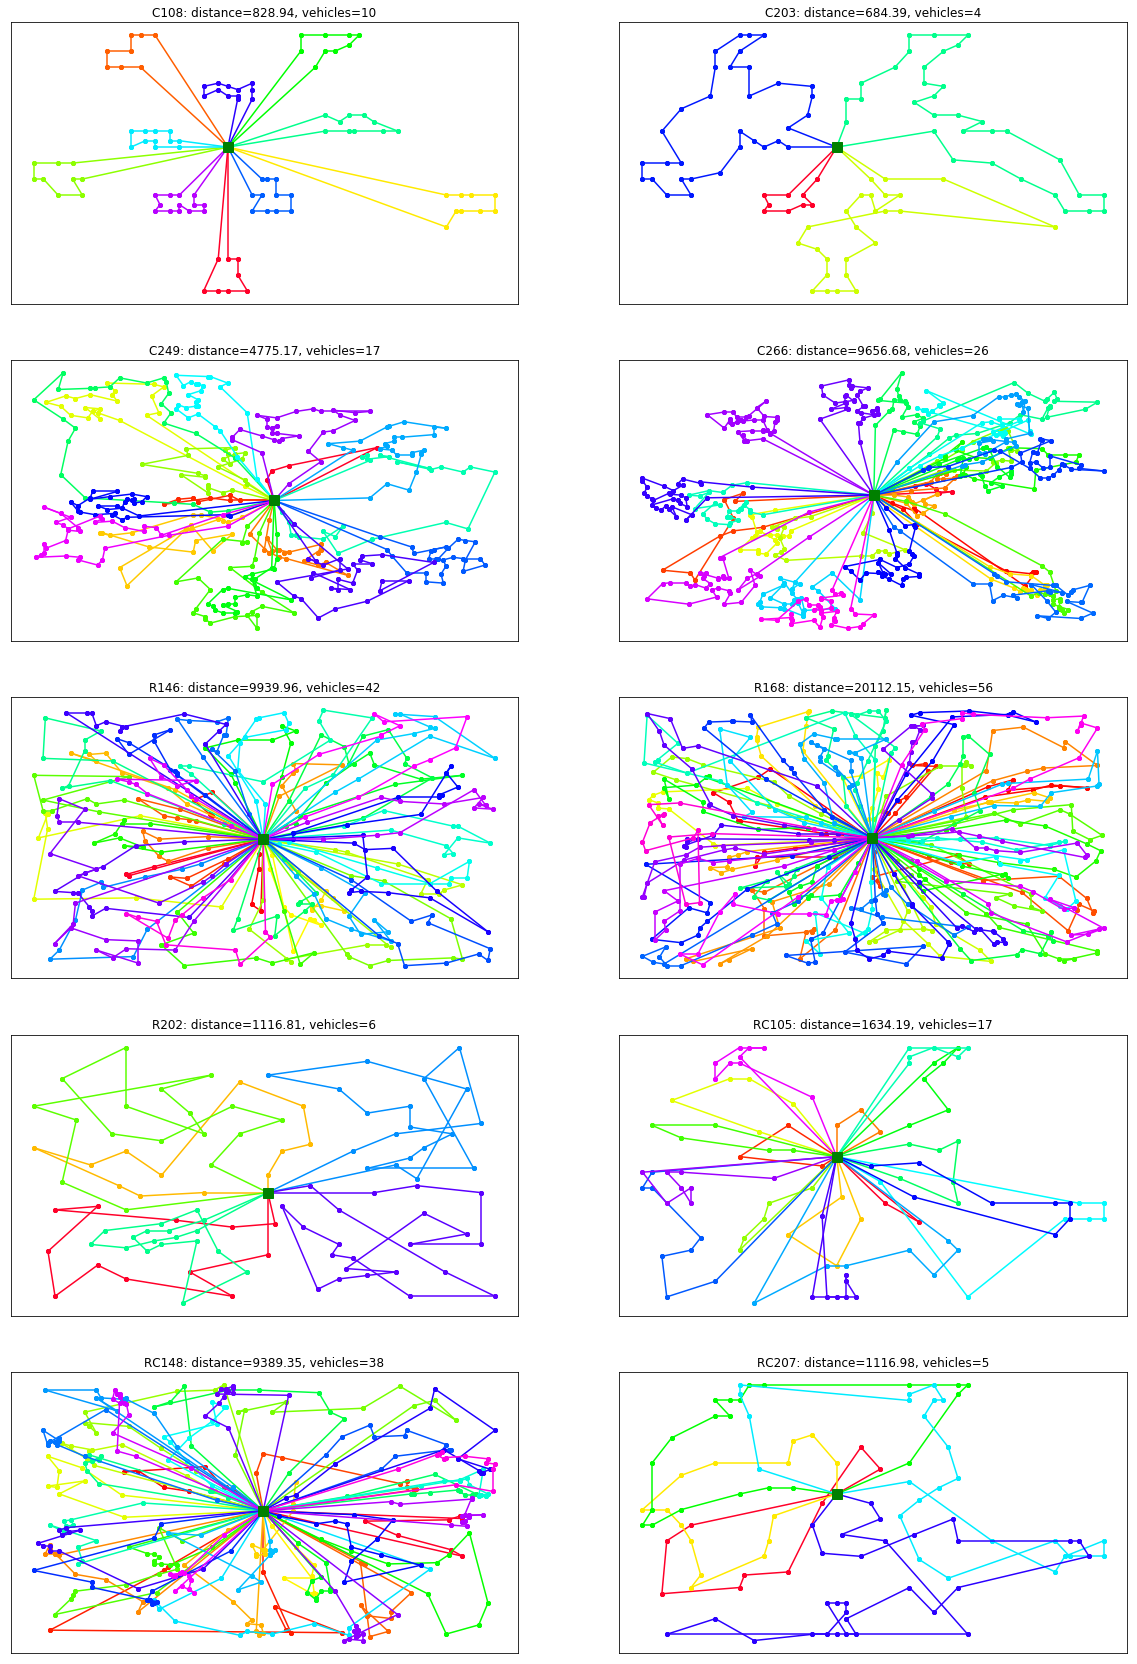

In [24]:
draw_best_solutions(res_df[['name', 'distance', 'n_vehicles', 'solution']].values)